torch.Size([64, 1, 28, 28])
torch.Size([64])


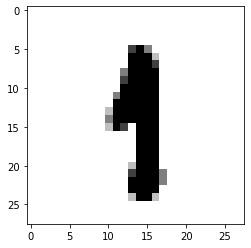

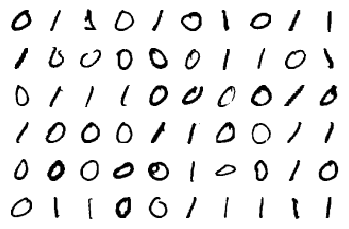

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import math
import matplotlib.pyplot as plt
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('./data/train', download=True, train=True, transform=transform)

valset = datasets.MNIST('./data/test', download=True, train=False, transform=transform)

#ONLY selecting digits 0 and 1 two classes

idx_train = trainset.targets==0
idx_train +=trainset.targets==1
idx_test = valset.targets==0
idx_test += valset.targets==1
idx_train = torch.squeeze(torch.nonzero(idx_train))
idx_test = torch.squeeze(torch.nonzero(idx_test))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler = torch.utils.data.SubsetRandomSampler(idx_train))

valloader = torch.utils.data.DataLoader(valset, batch_size=64, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_test))


dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');


figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
d = 784
n = len(idx_train)

In [2]:
#collecting data and flatennig and normalizing
i=0
for images,labels in trainloader:
    if i==0:
        y = labels.float()
        images = images.view(images.shape[0], -1)
        x = images
        x = images/torch.norm(images,dim=1)[:,None]
        i += 1
    else:    
        y = torch.cat((y,labels.float()),0)
        images = images.view(images.shape[0], -1)
        images = images/torch.norm(images,dim=1)[:,None]
        x = torch.cat((x,images),0)
        i += 1
y = 2*(y-0.5)
print(x.shape,y[:10],y.shape)

torch.Size([12665, 784]) tensor([ 1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.]) torch.Size([12665])


In [3]:
#computing H matrix
xtx = torch.mm(x,torch.transpose(x,0,1))
H = xtx*(math.pi - torch.acos(torch.clamp(xtx,-1.0,1.0)))/(2*math.pi)

0.3407555308948011 13.067377108634373 1470.588


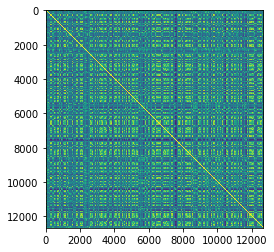

In [4]:
#y^TH^{-1}y
temp = np.linalg.solve(H, y)
ytHinvy = np.dot(temp,y)
print(math.sqrt(ytHinvy/n),ytHinvy/math.sqrt(n),ytHinvy)
plt.imshow(H)

In [5]:
#FINDING THE BEST LAMBDA
from scipy.optimize import minimize_scalar
def test(lambd):
    temp = H + lambd*np.eye(n)
    temp1 = np.linalg.solve(temp, y)#(H+lam)^{-1}y
    temp2 = np.matmul(H, temp1)#H(H+lam)^{-1}y
    ytHinvy = np.dot(temp1,temp2)#y^T(H+lam)^{-1}H(H+lam)^{-1}y
    return math.sqrt((2*ytHinvy/n)) + lambd*np.linalg.norm(temp1)*math.sqrt(1/n)
res = minimize_scalar(test,method='bounded',bounds = (0.001,10))
print(res)

     fun: 0.22605406878868528
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.4078612724210458


In [6]:
# TEST AND TRAIN BOUND FOR DIFFERENT LAMBDA (ERROR in INITIAL VERSION OF PAPER)
for lambd in [0,0.0001,0.001,0.082,0.5,2.4,10,50]:
    temp = H + lambd*np.eye(n)
    temp1 = np.linalg.solve(temp, y)#(H+lam)^{-1}y
    temp2 = np.matmul(H, temp1)#H(H+lam)^{-1}y
    ytHinvy = np.dot(temp1,temp2)#y^T(H+lam)^{-1}H(H+lam)^{-1}y
    print('lambda = ',lambd,' train =', lambd*np.linalg.norm(temp1)*math.sqrt(1/n),' test= ', math.sqrt((2*ytHinvy/n)) + lambd*np.linalg.norm(temp1)*math.sqrt(1/n))


lambda =  0  train = 0.0  test=  0.4819010983939345
lambda =  0.0001  train = 0.00012646275285212654  test=  0.4813626288543369
lambda =  0.001  train = 0.001240231217518239  test=  0.47664401275484486
lambda =  0.082  train = 0.04373526002793888  test=  0.3277092674100481
lambda =  0.5  train = 0.085767321020744  test=  0.24597971617382275
lambda =  2.4  train = 0.12340511276266009  test=  0.22605414261241516
lambda =  10  train = 0.1633819238357886  test=  0.2394986755531122
lambda =  50  train = 0.23677175804243294  test=  0.29349470193524174


In [14]:
#y^TH^{-1}y/n from 1 to n
lambd = 0.0
interv = 100
for i in range(2,n,interv):
    temp = H[:i,:i] + lambd*np.eye(i)
    temp1 = np.linalg.solve(temp, y[:i])#(H+lam)^{-1}y
    temp2 = np.matmul(H[:i,:i], temp1)#H(H+lam)^{-1}y
    rad_bound = np.dot(temp1,temp2)#y^T(H+lam)^{-1}H(H+lam)^{-1}y
    
    train_bound = lambd*np.linalg.norm(temp1)*math.sqrt(1/n)
    
    if i==2:
        complexity = np.array([rad_bound/i,rad_bound/math.pow(i,0.9), rad_bound/math.sqrt(i),rad_bound])
    else:
        complexity = np.vstack((complexity,[rad_bound/i,rad_bound/math.pow(i,0.9), rad_bound/math.sqrt(i),rad_bound]))
    if i%100 ==2:
        print(i)

torch.save(complexity,'complexity0_1_lambda0.pt')

2
102
202
302
402
502
602
702
802
902
1002
1102
1202
1302
1402
1502
1602
1702
1802
1902
2002
2102
2202
2302
2402
2502
2602
2702
2802
2902
3002
3102
3202
3302
3402
3502
3602
3702
3802
3902
4002
4102
4202
4302
4402
4502
4602
4702
4802
4902
5002
5102
5202
5302
5402
5502
5602
5702
5802
5902
6002
6102
6202
6302
6402
6502
6602
6702
6802
6902
7002
7102
7202
7302
7402
7502
7602
7702
7802
7902
8002
8102
8202
8302
8402
8502
8602
8702
8802
8902
9002
9102
9202
9302
9402
9502
9602
9702
9802
9902
10002
10102
10202
10302
10402
10502
10602
10702
10802
10902
11002
11102
11202
11302
11402
11502
11602
11702
11802
11902
12002
12102
12202
12302
12402
12502
12602


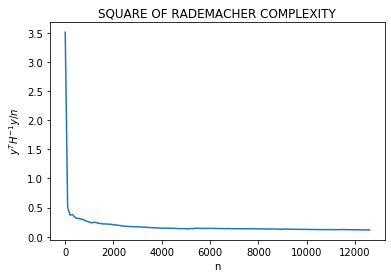

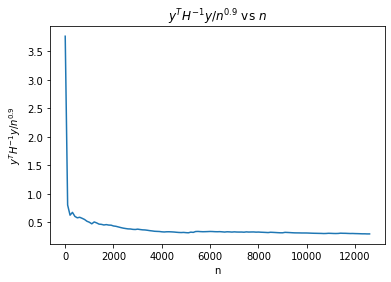

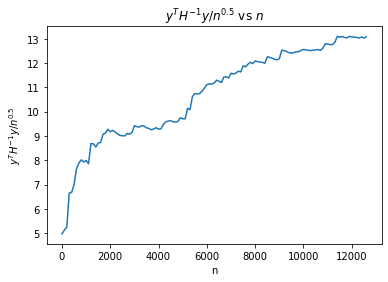

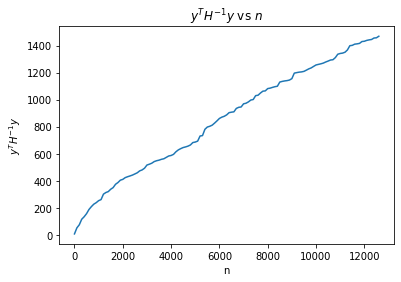

In [15]:
#ASSUMPTION HOLDS FOR epsilon = 0 lambda = 0
plt.figure(0)
plt.ylabel('$y^TH^{-1}y / n$')
plt.xlabel('n')
plt.title('SQUARE OF RADEMACHER COMPLEXITY')
plt.plot(list(range(2,n,interv)),complexity[:,0])
plt.savefig('assumption.png')


#ASSUMPTION HOLDS FOR epsilon = 0.1 lambda = 0
plt.figure(1)
plt.ylabel('$y^TH^{-1}y / n^{0.9}$')
plt.xlabel('n')
plt.title('$y^TH^{-1}y / n^{0.9}$ vs $n$')
plt.plot(list(range(2,n,interv)),complexity[:,1])
#plt.savefig('assumption.png')


#ASSUMPTION DOES NOT HOLD FOR epsilon = 0.5 lambda = 0
plt.figure(2)
plt.ylabel('$y^TH^{-1}y/n^{0.5}$')
plt.xlabel('n')
plt.title('$y^TH^{-1}y/n^{0.5}$ vs $n$')
plt.plot(list(range(2,n,interv)),complexity[:,2])


#ASSUMPTION DOES NOT HOLD FOR epsilon = 1 lambda = 0
plt.figure(3)
plt.ylabel('$y^TH^{-1}y$')
plt.xlabel('n')
plt.title('$y^TH^{-1}y$ vs $n$')
plt.plot(list(range(2,n,interv)),complexity[:,3])